# Reporte de Tiempo Promedio de Respuestas y Total de Tickets Cerrados por Agente

## Objetivo

El objetivo de este notebook es analizar el tiempo promedio de respuesta de tickets de renovaciones y el total de tickets cerrados por cada agente en nuestro sistema de soporte. Este análisis nos permitirá entender el rendimiento de cada agente en términos de eficiencia en la gestión de tickets y tiempos de respuesta.

## Contenido
 
1. Carga de Datos: Se cargarán los datos relevantes de los tickets de renovaciones, incluyendo la fecha de apertura, la fecha de cierre y el agente asignado.
2. Procesamiento de Datos: Se realizará un procesamiento de los datos para calcular el tiempo de respuesta de cada ticket y para agrupar los tickets por agente.
3. Análisis de Tiempos de Respuesta: Se calculará el tiempo promedio de respuesta de los tickets de renovaciones.
4. Análisis de Total de Tickets Cerrados por Agente: Se calculará el total de tickets cerrados por cada agente.
5. Visualización de Resultados: Se presentarán los resultados del análisis mediante gráficos y tablas para una mejor comprensión.

### NOTA:

Para este procese se toma en cuenta los siguientes aspectos:

- Los tickets que fueron creados por el cliente fuera del horario laboral (08:00 - 18:59) no se tomarán en cuenta en el cálculo del tiempo de respuesta.
- Considerando que contamos unicamente con las fecha de apertura y cierre de los tickets(No se cuenta con fechas y horas de reapertura de un ticket). No se tomaron en cuenta para el analisis aquellos tickets que fueron abiertos y cerrados en diferentes días.
- Se considera que el tiempo de respuesta de un ticket es el tiempo transcurrido entre la apertura y el cierre del mismo.
- Se considera como el numero total de Respuestas de un Agente a la suma del numero de Reinicios del contados + 1. Se adiciona el valor de 1 puesto que representa la creacion del ticket y no esta incluido dentro del Reinicio del contador.
- 

In [1]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine
import psycopg2
import io

In [2]:
# Configurar las fechas deseadas para el filtrado de los datos en formato 'YYYY-MM-DD'
initial_date = '2024-05-01'
end_date = '2024-05-31'

# Configurar las horas deseadas para el filtrado de los datos en formato 'HH:MM:SS' (Horas Laborales en este caso)
initial_hour = pd.to_datetime('08:00:00').hour
end_hour = pd.to_datetime('18:59:00').hour

# Configurar la ubicacion del archivo CSV con los reportes generados
path_file = 'Reports/Reportes Ticketera.csv'

In [3]:
# Se carga la data original. Para futuras modifcaciones 

df_original = pd.read_csv(path_file, sep=',')
df_original.head(10)

,Número de Ticket,Fecha de creación,Asunto,De,De correo electrónico,Prioridad,Departamento,Temas de ayuda,Fuente,Estado actual,...,Atrasado,Merged,Linked,Respondido,Agente asignado,Equipo asignado,Cuenta de hilos,Reabrir contador,Recuento de datos adjuntos,Task Count
0,SD-191230,2024-06-05 13:34:08,RENOVACION%FIRMA%ELECTRONICA,Paola Poggi,ppoggibr@gmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,No,Sí,Gissela Vega,NaN,2.0,NaN,NaN,NaN
1,SD-191229,2024-06-05 13:17:02,RE: ¡No te pierdas nuestro descuento exclusivo...,milton orbea,milton1206@hotmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,No,Sí,Gissela Vega,NaN,4.0,1.0,NaN,NaN
2,SD-191228,2024-06-05 13:15:02,Renovación firma electrónica,Kelly Gonzalez Rodriguez,kellygonzalez40@hotmail.com,Low,Renovaciones,RENOVACIONES - FACTURADO,Email,Closed,...,No,No,No,Sí,Gissela Vega,NaN,2.0,NaN,2.0,NaN
3,SD-191226,2024-06-05 13:02:02,Yo autorizo a la Renovación de mi firma electr...,Xavier Macias,xmacias-83@hotmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,No,Sí,Gissela Vega,NaN,2.0,NaN,NaN,NaN
4,SD-191225,2024-06-05 12:54:02,renovacion firma electronica,Martha Quiñonez,negra_1963@hotmail.com,Low,Renovaciones,RENOVACIONES - FACTURADO,Email,Closed,...,No,No,No,Sí,Gissela Vega,NaN,2.0,NaN,NaN,NaN
5,SD-191224,2024-06-05 12:52:02,[No Subject],JEFFERSON MENDIETA CEDEÑO,tremen21@outlook.com,Low,Renovaciones,RENOVACIONES - FACTURADO,Email,Closed,...,No,No,No,Sí,Gissela Vega,NaN,2.0,NaN,NaN,NaN
6,SD-191222,2024-06-05 12:44:02,Firma electrónica,Xavier Macias,xaviermaciasrizo@gmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,No,Sí,Gissela Vega,NaN,2.0,NaN,NaN,NaN
7,SD-191220,2024-06-05 12:30:03,"Mi estimado buenas tardes, estoy intentando ha...",Andres Arias,andreshh-11@hotmail.com,Low,Renovaciones,RENOVACIONES - FACTURADO,Email,Closed,...,No,No,No,Sí,Gissela Vega,NaN,2.0,NaN,NaN,NaN
8,SD-191219,2024-06-05 12:22:08,URGENTE RENOVACION FIRMA ELECTRONICA,TOAPANTA IMPORTADORES,toapantactr@gmail.com,Low,Renovaciones,RENOVACIONES - FACTURADO,Email,Closed,...,No,No,No,Sí,Gissela Vega,NaN,2.0,NaN,NaN,NaN
9,SD-191218,2024-06-05 12:10:10,ASOCIACION MONTECRISTI INFORMACION,ASO MONTECRISTI,asomontecristi@gmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,No,Sí,Gissela Vega,NaN,2.0,NaN,7.0,NaN


In [4]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42724 entries, 0 to 42723
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Número de Ticket            42724 non-null  object 
 1   Fecha de creación           42724 non-null  object 
 2   Asunto                      42723 non-null  object 
 3   De                          42724 non-null  object 
 4   De correo electrónico       42724 non-null  object 
 5   Prioridad                   42724 non-null  object 
 6   Departamento                42724 non-null  object 
 7   Temas de ayuda              42724 non-null  object 
 8   Fuente                      42724 non-null  object 
 9   Estado actual               42724 non-null  object 
 10  Última actualización        42724 non-null  object 
 11  Fecha de expiración de SLA  37811 non-null  object 
 12  Plan SLA                    42724 non-null  object 
 13  Fecha de Vencimiento        0 n

In [5]:
# Se procede a eliminar aquellos tickets cerrados con e tema de Notificaciones Bancarias
df = df_original.copy()
df = df[df['Temas de ayuda'] != 'RENOVACIONES - NOTIFICACION BANCARIA']

In [6]:
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41900 entries, 0 to 41899
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Número de Ticket            41900 non-null  object 
 1   Fecha de creación           41900 non-null  object 
 2   Asunto                      41899 non-null  object 
 3   De                          41900 non-null  object 
 4   De correo electrónico       41900 non-null  object 
 5   Prioridad                   41900 non-null  object 
 6   Departamento                41900 non-null  object 
 7   Temas de ayuda              41900 non-null  object 
 8   Fuente                      41900 non-null  object 
 9   Estado actual               41900 non-null  object 
 10  Última actualización        41900 non-null  object 
 11  Fecha de expiración de SLA  37052 non-null  object 
 12  Plan SLA                    41900 non-null  object 
 13  Fecha de Vencimiento        0 n

In [7]:

# Filtrado desde la fecha inicial hasta la fecha  final deseada
df['Fecha de creación'] = pd.to_datetime(df['Fecha de creación'])
df['Fecha de cierre'] = pd.to_datetime(df['Fecha de cierre'])


df = df[df['Fecha de creación'] >= initial_date]
df = df[df['Fecha de creación'] <= end_date]
df = df.reset_index(drop=True)
df

,Número de Ticket,Fecha de creación,Asunto,De,De correo electrónico,Prioridad,Departamento,Temas de ayuda,Fuente,Estado actual,...,Atrasado,Merged,Linked,Respondido,Agente asignado,Equipo asignado,Cuenta de hilos,Reabrir contador,Recuento de datos adjuntos,Task Count
0,SD-190551,2024-05-30 17:10:10,RENOVACION LEGACY CONSULTING - ANDRES PADILLA,Andres Padilla,aspn100@outlook.es,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,No,Sí,Julissa Alfonzo,NaN,9.0,2.0,NaN,NaN
1,SD-190533,2024-05-30 16:28:15,Renovación firma electrónica,Alvaro Sandoval,sandovalalvaro1991@gmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,No,Sí,Julissa Alfonzo,NaN,3.0,NaN,NaN,NaN
2,SD-190523,2024-05-30 16:02:02,Documento Electronico No 001-006-000395889,factura,factura@mutualistapichincha.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,No,Sí,Julissa Alfonzo,NaN,3.0,NaN,2.0,NaN
3,SD-190517,2024-05-30 15:52:01,Activación de firma electrónica,Andrea Pachar Figueroa,andreina__1990@hotmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,No,Sí,Julissa Alfonzo,NaN,3.0,NaN,NaN,NaN
4,SD-190516,2024-05-30 15:42:01,Renovación firma electrónica ARBOL DE ORO A.D....,Tannya Cepeda,tcepeda@seguroslaunion.com,Low,Renovaciones,RENOVACIONES - FACTURADO,Email,Closed,...,No,No,No,Sí,Gissela Vega,NaN,20.0,7.0,13.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,SD-185252,2024-05-01 09:14:02,RENOVACION%FIRMA%ELECTRONICA,Nancy Verdesoto,nancyverdesoto@hotmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,No,Sí,Julissa Alfonzo,NaN,3.0,NaN,NaN,NaN
638,SD-185251,2024-05-01 09:14:00,RENOVACIÓN FIRMAS,Andrea Matiz,andrea.matiz@arcotel.gob.ec,High,Renovaciones,RENOVACIONES - INFORMACIÓN,Other,Closed,...,No,No,No,Sí,Julissa Alfonzo,NaN,3.0,NaN,NaN,NaN
639,SD-185245,2024-05-01 08:54:01,RENOVACION%IRMA%LECTRONICA,LUIS ALFREDO GONZALEZ FLORES,luiyialf@yahoo.es,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,No,Sí,Julissa Alfonzo,NaN,6.0,1.0,NaN,NaN
640,SD-185237,2024-05-01 07:29:02,Re: ¡Tú firma en ARCHIVO está caducado! Renuev...,Patricio Loor Zamora,patricio.loorz21@gmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,No,Sí,Julissa Alfonzo,NaN,3.0,NaN,NaN,NaN


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Número de Ticket            642 non-null    object        
 1   Fecha de creación           642 non-null    datetime64[ns]
 2   Asunto                      642 non-null    object        
 3   De                          642 non-null    object        
 4   De correo electrónico       642 non-null    object        
 5   Prioridad                   642 non-null    object        
 6   Departamento                642 non-null    object        
 7   Temas de ayuda              642 non-null    object        
 8   Fuente                      642 non-null    object        
 9   Estado actual               642 non-null    object        
 10  Última actualización        642 non-null    object        
 11  Fecha de expiración de SLA  604 non-null    object        

In [9]:
# Filtrado de los tickets que fueron creados dentro del horario laboral (08:00 - 18:59)
df_in_range = df[df['Fecha de creación'].dt.hour > initial_hour]
df_in_range = df_in_range[df_in_range['Fecha de creación'].dt.hour < end_hour]

#Filtrado de los tickets que fueron cerrados en el mismo día de su creación
df_in_range = df_in_range[df_in_range['Fecha de cierre'].dt.date == df_in_range['Fecha de creación'].dt.date]

#Calculo del tiempo de respuesta de cada ticket
df_in_range['Time_Open_Ticket'] = df_in_range['Fecha de cierre'] - df_in_range['Fecha de creación']
df_in_range.head(10)

,Número de Ticket,Fecha de creación,Asunto,De,De correo electrónico,Prioridad,Departamento,Temas de ayuda,Fuente,Estado actual,...,Merged,Linked,Respondido,Agente asignado,Equipo asignado,Cuenta de hilos,Reabrir contador,Recuento de datos adjuntos,Task Count,Time_Open_Ticket
0,SD-190551,2024-05-30 17:10:10,RENOVACION LEGACY CONSULTING - ANDRES PADILLA,Andres Padilla,aspn100@outlook.es,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,Sí,Julissa Alfonzo,NaN,9.0,2.0,NaN,NaN,0 days 00:20:44
1,SD-190533,2024-05-30 16:28:15,Renovación firma electrónica,Alvaro Sandoval,sandovalalvaro1991@gmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,Sí,Julissa Alfonzo,NaN,3.0,NaN,NaN,NaN,0 days 00:23:15
2,SD-190523,2024-05-30 16:02:02,Documento Electronico No 001-006-000395889,factura,factura@mutualistapichincha.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,Sí,Julissa Alfonzo,NaN,3.0,NaN,2.0,NaN,0 days 00:09:53
3,SD-190517,2024-05-30 15:52:01,Activación de firma electrónica,Andrea Pachar Figueroa,andreina__1990@hotmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,Sí,Julissa Alfonzo,NaN,3.0,NaN,NaN,NaN,0 days 00:12:31
5,SD-190515,2024-05-30 15:33:13,RENOVACIÓN DE FIRMA,Gissela Argudo,gissela.argudo@hotmail.com,High,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,Sí,Julissa Alfonzo,NaN,3.0,NaN,NaN,NaN,0 days 00:00:14
6,SD-190501,2024-05-30 14:10:08,Renovación firma electronica en archivo C.I. 1...,Carolina Llumiquinga,cllumiquinga@lacec.com.ec,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,Sí,Julissa Alfonzo,NaN,3.0,NaN,2.0,NaN,0 days 00:10:43
7,SD-190500,2024-05-30 13:49:02,[No Subject],Tana Mena,tanamena27@gmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,Sí,Julissa Alfonzo,NaN,3.0,NaN,NaN,NaN,0 days 00:09:45
8,SD-190497,2024-05-30 13:41:02,Re: ¡Tú firma en ARCHIVO está caducado! Renuev...,Anthony Toledo,anthonytoledo1161279@gmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,Sí,Julissa Alfonzo,NaN,6.0,1.0,NaN,NaN,0 days 00:36:00
9,SD-190495,2024-05-30 13:12:02,TOKEN VIGENTE CADUCADO?,MONIR Cuidado Tricológico,monir.tricocapilar@gmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,Sí,Julissa Alfonzo,NaN,3.0,NaN,NaN,NaN,0 days 00:40:35
10,SD-190493,2024-05-30 12:54:02,Fwd:,Carlos Manrique,negcom.ec@gmail.com,Low,Renovaciones,RENOVACIONES - CARGAR PAGO Y VIDEO,Email,Closed,...,No,No,Sí,Julissa Alfonzo,NaN,6.0,1.0,NaN,NaN,0 days 03:59:00


In [10]:
# Funcion para asignar un valor de 1 a los tickets que no han sido reabiertos y un valor adicionado a 1 a los tickets que han sido reabiertos
def asignar_valor(contador):
    if pd.isnull(contador):
        return 1
    else:
        return contador + 1

In [11]:
# Funcion para asignar un valor de 1 a los tickets que no han sido reabiertos y un valor adicionado a 1 a los tickets que han sido reabiertos
df_in_range['Response by Ticket'] = df_in_range['Reabrir contador'].apply(lambda x: asignar_valor(x))
df_in_range.head(10)

,Número de Ticket,Fecha de creación,Asunto,De,De correo electrónico,Prioridad,Departamento,Temas de ayuda,Fuente,Estado actual,...,Linked,Respondido,Agente asignado,Equipo asignado,Cuenta de hilos,Reabrir contador,Recuento de datos adjuntos,Task Count,Time_Open_Ticket,Response by Ticket
0,SD-190551,2024-05-30 17:10:10,RENOVACION LEGACY CONSULTING - ANDRES PADILLA,Andres Padilla,aspn100@outlook.es,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,Sí,Julissa Alfonzo,NaN,9.0,2.0,NaN,NaN,0 days 00:20:44,3.0
1,SD-190533,2024-05-30 16:28:15,Renovación firma electrónica,Alvaro Sandoval,sandovalalvaro1991@gmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,Sí,Julissa Alfonzo,NaN,3.0,NaN,NaN,NaN,0 days 00:23:15,1.0
2,SD-190523,2024-05-30 16:02:02,Documento Electronico No 001-006-000395889,factura,factura@mutualistapichincha.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,Sí,Julissa Alfonzo,NaN,3.0,NaN,2.0,NaN,0 days 00:09:53,1.0
3,SD-190517,2024-05-30 15:52:01,Activación de firma electrónica,Andrea Pachar Figueroa,andreina__1990@hotmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,Sí,Julissa Alfonzo,NaN,3.0,NaN,NaN,NaN,0 days 00:12:31,1.0
5,SD-190515,2024-05-30 15:33:13,RENOVACIÓN DE FIRMA,Gissela Argudo,gissela.argudo@hotmail.com,High,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,Sí,Julissa Alfonzo,NaN,3.0,NaN,NaN,NaN,0 days 00:00:14,1.0
6,SD-190501,2024-05-30 14:10:08,Renovación firma electronica en archivo C.I. 1...,Carolina Llumiquinga,cllumiquinga@lacec.com.ec,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,Sí,Julissa Alfonzo,NaN,3.0,NaN,2.0,NaN,0 days 00:10:43,1.0
7,SD-190500,2024-05-30 13:49:02,[No Subject],Tana Mena,tanamena27@gmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,Sí,Julissa Alfonzo,NaN,3.0,NaN,NaN,NaN,0 days 00:09:45,1.0
8,SD-190497,2024-05-30 13:41:02,Re: ¡Tú firma en ARCHIVO está caducado! Renuev...,Anthony Toledo,anthonytoledo1161279@gmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,Sí,Julissa Alfonzo,NaN,6.0,1.0,NaN,NaN,0 days 00:36:00,2.0
9,SD-190495,2024-05-30 13:12:02,TOKEN VIGENTE CADUCADO?,MONIR Cuidado Tricológico,monir.tricocapilar@gmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,Sí,Julissa Alfonzo,NaN,3.0,NaN,NaN,NaN,0 days 00:40:35,1.0
10,SD-190493,2024-05-30 12:54:02,Fwd:,Carlos Manrique,negcom.ec@gmail.com,Low,Renovaciones,RENOVACIONES - CARGAR PAGO Y VIDEO,Email,Closed,...,No,Sí,Julissa Alfonzo,NaN,6.0,1.0,NaN,NaN,0 days 03:59:00,2.0


In [12]:
# Se agrupan los tickets por agente asignado y se calcula el total de respuestas y el tiempo total de respuesta
df_in_range['Total Responses'] = df_in_range.groupby('Agente asignado')['Response by Ticket'].transform('sum')
df_in_range['Total Time'] = df_in_range.groupby('Agente asignado')['Time_Open_Ticket'].transform('sum')
df_in_range.head(10)

,Número de Ticket,Fecha de creación,Asunto,De,De correo electrónico,Prioridad,Departamento,Temas de ayuda,Fuente,Estado actual,...,Agente asignado,Equipo asignado,Cuenta de hilos,Reabrir contador,Recuento de datos adjuntos,Task Count,Time_Open_Ticket,Response by Ticket,Total Responses,Total Time
0,SD-190551,2024-05-30 17:10:10,RENOVACION LEGACY CONSULTING - ANDRES PADILLA,Andres Padilla,aspn100@outlook.es,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,Julissa Alfonzo,NaN,9.0,2.0,NaN,NaN,0 days 00:20:44,3.0,553.0,8 days 06:42:30
1,SD-190533,2024-05-30 16:28:15,Renovación firma electrónica,Alvaro Sandoval,sandovalalvaro1991@gmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,Julissa Alfonzo,NaN,3.0,NaN,NaN,NaN,0 days 00:23:15,1.0,553.0,8 days 06:42:30
2,SD-190523,2024-05-30 16:02:02,Documento Electronico No 001-006-000395889,factura,factura@mutualistapichincha.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,Julissa Alfonzo,NaN,3.0,NaN,2.0,NaN,0 days 00:09:53,1.0,553.0,8 days 06:42:30
3,SD-190517,2024-05-30 15:52:01,Activación de firma electrónica,Andrea Pachar Figueroa,andreina__1990@hotmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,Julissa Alfonzo,NaN,3.0,NaN,NaN,NaN,0 days 00:12:31,1.0,553.0,8 days 06:42:30
5,SD-190515,2024-05-30 15:33:13,RENOVACIÓN DE FIRMA,Gissela Argudo,gissela.argudo@hotmail.com,High,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,Julissa Alfonzo,NaN,3.0,NaN,NaN,NaN,0 days 00:00:14,1.0,553.0,8 days 06:42:30
6,SD-190501,2024-05-30 14:10:08,Renovación firma electronica en archivo C.I. 1...,Carolina Llumiquinga,cllumiquinga@lacec.com.ec,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,Julissa Alfonzo,NaN,3.0,NaN,2.0,NaN,0 days 00:10:43,1.0,553.0,8 days 06:42:30
7,SD-190500,2024-05-30 13:49:02,[No Subject],Tana Mena,tanamena27@gmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,Julissa Alfonzo,NaN,3.0,NaN,NaN,NaN,0 days 00:09:45,1.0,553.0,8 days 06:42:30
8,SD-190497,2024-05-30 13:41:02,Re: ¡Tú firma en ARCHIVO está caducado! Renuev...,Anthony Toledo,anthonytoledo1161279@gmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,Julissa Alfonzo,NaN,6.0,1.0,NaN,NaN,0 days 00:36:00,2.0,553.0,8 days 06:42:30
9,SD-190495,2024-05-30 13:12:02,TOKEN VIGENTE CADUCADO?,MONIR Cuidado Tricológico,monir.tricocapilar@gmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,Julissa Alfonzo,NaN,3.0,NaN,NaN,NaN,0 days 00:40:35,1.0,553.0,8 days 06:42:30
10,SD-190493,2024-05-30 12:54:02,Fwd:,Carlos Manrique,negcom.ec@gmail.com,Low,Renovaciones,RENOVACIONES - CARGAR PAGO Y VIDEO,Email,Closed,...,Julissa Alfonzo,NaN,6.0,1.0,NaN,NaN,0 days 03:59:00,2.0,553.0,8 days 06:42:30


In [13]:
# Se calcula el tiempo promedio de respuesta de los tickets de renovaciones
df_in_range['Average Time'] = df_in_range['Total Time'] / df_in_range['Total Responses']
df_in_range['Average Time'] = df_in_range['Average Time'].apply(lambda x: timedelta(seconds=round(x.total_seconds())))
df_final_report = df_in_range.groupby('Agente asignado').agg({'Total Responses': 'first', 'Total Time': 'first', 'Average Time': 'first'}).reset_index()
df_final_report.sort_values(by='Average Time', ascending=False, inplace=True)
df_final_report

,Agente asignado,Total Responses,Total Time,Average Time
0,Carlos Giler,9.0,0 days 18:07:13,0 days 02:00:48
1,Cristhian Benalcazar,13.0,0 days 14:52:57,0 days 01:08:41
2,Erika Duran,23.0,0 days 13:39:47,0 days 00:35:39
3,Ginella Alcivar,32.0,0 days 18:07:23,0 days 00:33:59
5,Jorge Asanza,38.0,0 days 20:41:57,0 days 00:32:41
6,Julissa Alfonzo,553.0,8 days 06:42:30,0 days 00:21:34
4,Guillermo Garcia,1.0,0 days 00:00:01,0 days 00:00:01


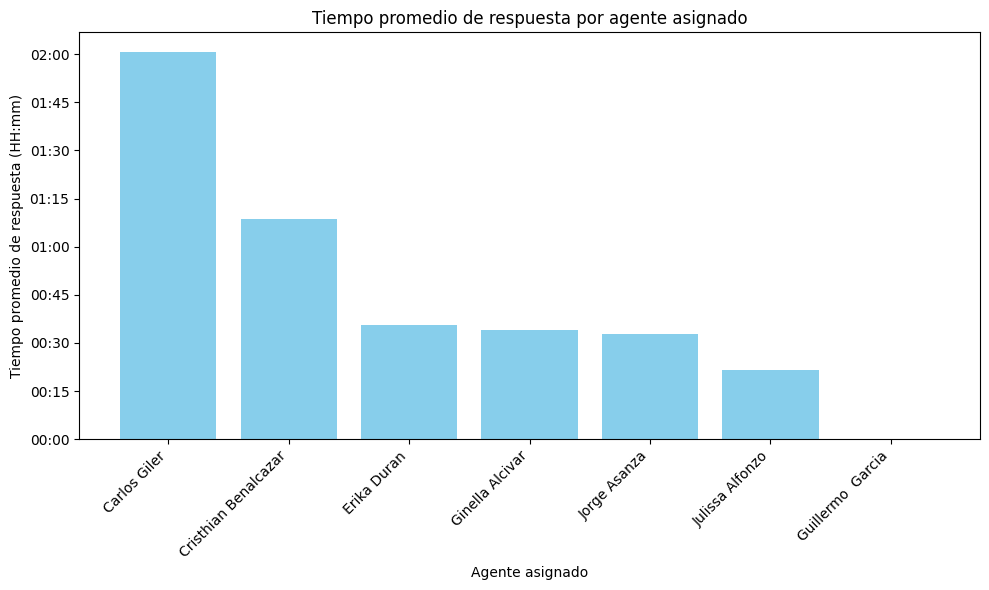

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Grafico de barras para mostrar el tiempo promedio de respuesta por agente asignado
agentes = df_final_report['Agente asignado']
tiempos_promedio = df_final_report['Average Time']

tiempos_promedio_segundos = tiempos_promedio.dt.total_seconds()

# Generar una lista de intervalos de tiempo en incrementos de 15 minutos entre 0 y 2 horas
intervalos = np.arange(0, 2*3600+1, 15*60)  # 2 horas * 3600 segundos/hora + 1 para incluir el último valor
etiquetas_intervalos = ['{:02}:{:02}'.format(int(segundos // 3600), int((segundos % 3600) // 60)) for segundos in intervalos]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(agentes, tiempos_promedio_segundos, color='skyblue')

# Añadir etiquetas y título
plt.xlabel('Agente asignado')
plt.ylabel('Tiempo promedio de respuesta (HH:mm)')
plt.title('Tiempo promedio de respuesta por agente asignado')
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x para mejorar la legibilidad

#intervalos = intervalos * 1000
# Establecer las etiquetas del eje y en intervalos de 15 minutos de 0 a 2 horas
plt.yticks(intervalos, etiquetas_intervalos)

# Mostrar el gráfico
plt.tight_layout()  # Ajustar el diseño para evitar recorte de etiquetas
plt.show()


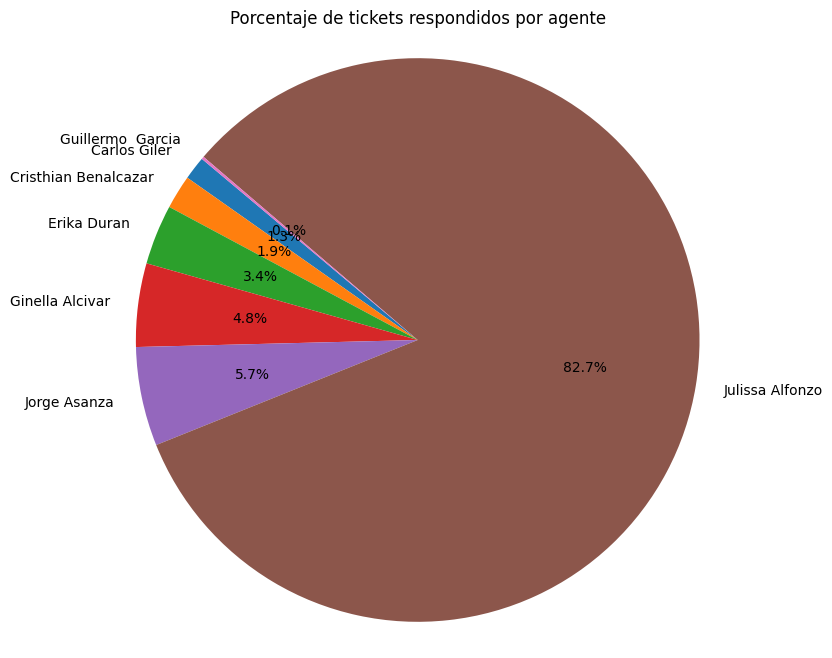

In [15]:
import matplotlib.pyplot as plt

# Datos para el gráfico de pasteles
agentes = df_final_report['Agente asignado']
total_respuestas = df_final_report['Total Responses']

# Crear el gráfico de pasteles
plt.figure(figsize=(8, 8))
plt.pie(total_respuestas, labels=agentes, autopct='%1.1f%%', startangle=140)

# Añadir título
plt.title('Porcentaje de tickets respondidos por agente')

# Mostrar el gráfico
plt.axis('equal')  # Asegurar que el gráfico sea circular
plt.show()


# COMPROBACION DE LOS RESULTADOS IGNORARA

In [16]:
test = df[df['Agente asignado'] == 'Cristhian Benalcazar']
test

,Número de Ticket,Fecha de creación,Asunto,De,De correo electrónico,Prioridad,Departamento,Temas de ayuda,Fuente,Estado actual,...,Atrasado,Merged,Linked,Respondido,Agente asignado,Equipo asignado,Cuenta de hilos,Reabrir contador,Recuento de datos adjuntos,Task Count
40,SD-190300,2024-05-29 14:35:17,RENOVACIÓN DE FIRMA ELECTRONICA,Victoriaargoty,victoriaargoty@gmail.com,High,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,No,Sí,Cristhian Benalcazar,NaN,5.0,1.0,NaN,NaN
149,SD-189951,2024-05-26 16:44:03,Re: ¡Tú firma en ARCHIVO está próxima a caduca...,janet lores,loresjanet72@gmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,No,Sí,Cristhian Benalcazar,NaN,2.0,NaN,NaN,NaN
150,SD-189949,2024-05-26 14:40:03,Re: ¡Tú firma en ARCHIVO está próxima a caduca...,gaby Bajaña,gbajanac@gmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,No,Sí,Cristhian Benalcazar,NaN,2.0,NaN,NaN,NaN
152,SD-189945,2024-05-26 12:26:01,Ecuaprotein - Retenciones,Jorge Alejandro Alvarado Cortez,jorge.alvarado@symrise.com,Low,Renovaciones,RENOVACIONES - CARGAR PAGO Y VIDEO,Email,Closed,...,No,No,No,Sí,Cristhian Benalcazar,NaN,2.0,NaN,1.0,NaN
251,SD-189095,2024-05-18 13:04:04,"Gráficos, datos y noticias de Dow Jones Indust...",Andrés Benites Félix,andresbenfel@icloud.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Resolved,...,No,No,No,No,Cristhian Benalcazar,NaN,2.0,NaN,NaN,NaN
252,SD-189021,2024-05-18 10:19:02,Información,Psicólogo Clínico Santiago Alulema Msc,psicologosanti.alu@gmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,No,No,Cristhian Benalcazar,NaN,6.0,1.0,2.0,NaN
253,SD-188977,2024-05-17 20:12:05,Re: ¡Tú firma en TOKEN está próxima a caducar!...,Galo Tinoco,galot.gt@outlook.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,No,Sí,Cristhian Benalcazar,NaN,2.0,NaN,NaN,NaN
254,SD-188976,2024-05-17 19:54:06,[No Subject],Deisy Veronica Tigrero Villamar,dbriny_07@hotmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,No,Sí,Cristhian Benalcazar,NaN,2.0,NaN,NaN,NaN
258,SD-188903,2024-05-17 13:16:06,Renovación Firma Electronica,Emmi Pikler,emmiacp@gmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,No,Sí,Cristhian Benalcazar,NaN,5.0,1.0,1.0,NaN
372,SD-187652,2024-05-12 10:56:03,RENOVACION%FIRMA%ELECTRONICA,NAYLA TERESA GALARZA,na.y.la@hotmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,No,Sí,Cristhian Benalcazar,NaN,2.0,NaN,NaN,NaN


In [17]:
indices_filas = [593, 588, 408, 407, 406, 403, 272, 271, 165, 164, 162, 161]
test = df.iloc[indices_filas]
test

,Número de Ticket,Fecha de creación,Asunto,De,De correo electrónico,Prioridad,Departamento,Temas de ayuda,Fuente,Estado actual,...,Atrasado,Merged,Linked,Respondido,Agente asignado,Equipo asignado,Cuenta de hilos,Reabrir contador,Recuento de datos adjuntos,Task Count
593,SD-185491,2024-05-01 18:10:06,TRANSFERENCIA BANCA ELECTRONICA BANCO PICHINCHA,banco,banco@pichincha.com,Low,Renovaciones,RENOVACIONES - CARGAR PAGO Y VIDEO,Email,Closed,...,No,No,No,Sí,Erika Duran,NaN,2.0,NaN,NaN,NaN
588,SD-185503,2024-05-02 03:46:04,Incoming emails blocked!,cPanel,diskominfo@benermeriahkab.go.id,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,No,Sí,Jorge Asanza,NaN,2.0,NaN,NaN,NaN
408,SD-187278,2024-05-09 10:32:03,Certificado por expirar - RSuquillo,Cristina Belem Pino,cbpino@dos.com.ec,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,No,Sí,Ginella Alcivar,NaN,25.0,8.0,4.0,NaN
407,SD-187280,2024-05-09 10:44:03,Re: CADUCADOS 13 AL 19 MAYO PRIMERA NOTIFICACI...,Maria Chonillo,mareug2001@yahoo.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,No,Sí,Julissa Alfonzo,NaN,2.0,NaN,NaN,NaN
406,SD-187305,2024-05-09 11:48:02,RV: Renovación firmas electrónicas ADO / SUBIN...,Tannya Cepeda,tcepeda@seguroslaunion.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,No,Sí,Julissa Alfonzo,NaN,30.0,9.0,13.0,NaN
403,SD-187323,2024-05-09 15:04:01,Renovación de firma de Katty Peñaherreta,FIN Laura Cajias,lcajiasp@claro.com.ec,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,No,Sí,Julissa Alfonzo,NaN,8.0,1.0,4.0,NaN
272,SD-188449,2024-05-16 13:02:02,Renovación de firma electrónica,Tatiana Calderón,od.tatianacp@gmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,No,Sí,Julissa Alfonzo,NaN,6.0,1.0,NaN,NaN
271,SD-188457,2024-05-16 13:17:05,RENOVACION FIRMA ELECTRONICA,Evelin Fernanda Miranda Benitez,emiranda@Gestiona.ec,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,No,Sí,Julissa Alfonzo,NaN,6.0,1.0,3.0,NaN
165,SD-189598,2024-05-23 13:40:05,[No Subject],Lilibeth Tapia,lilibethtapia727@gmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,No,Sí,Julissa Alfonzo,NaN,3.0,NaN,NaN,NaN
164,SD-189601,2024-05-23 14:39:05,RENOVACION FIRMA ELECTRÓNICA,Monica Villalta,moneliv@yahoo.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,No,No,No,Sí,Julissa Alfonzo,NaN,3.0,NaN,NaN,NaN


In [18]:
valores_tickets = ['SD-186156', 'SD-186193', 'SD-187621', 'SD-187623', 'SD-187626', 
                   'SD-187652', 'SD-189021', 'SD-189095', 'SD-189944', 'SD-189945', 
                   'SD-189949', 'SD-189951']
filas_especificas = df_in_range[df_in_range['Número de Ticket'].isin(valores_tickets)]

In [19]:
filas_especificas

,Número de Ticket,Fecha de creación,Asunto,De,De correo electrónico,Prioridad,Departamento,Temas de ayuda,Fuente,Estado actual,...,Equipo asignado,Cuenta de hilos,Reabrir contador,Recuento de datos adjuntos,Task Count,Time_Open_Ticket,Response by Ticket,Total Responses,Total Time,Average Time
149,SD-189951,2024-05-26 16:44:03,Re: ¡Tú firma en ARCHIVO está próxima a caduca...,janet lores,loresjanet72@gmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,NaN,2.0,NaN,NaN,NaN,0 days 00:12:42,1.0,13.0,0 days 14:52:57,0 days 01:08:41
150,SD-189949,2024-05-26 14:40:03,Re: ¡Tú firma en ARCHIVO está próxima a caduca...,gaby Bajaña,gbajanac@gmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,NaN,2.0,NaN,NaN,NaN,0 days 00:47:38,1.0,13.0,0 days 14:52:57,0 days 01:08:41
152,SD-189945,2024-05-26 12:26:01,Ecuaprotein - Retenciones,Jorge Alejandro Alvarado Cortez,jorge.alvarado@symrise.com,Low,Renovaciones,RENOVACIONES - CARGAR PAGO Y VIDEO,Email,Closed,...,NaN,2.0,NaN,1.0,NaN,0 days 02:05:28,1.0,13.0,0 days 14:52:57,0 days 01:08:41
251,SD-189095,2024-05-18 13:04:04,"Gráficos, datos y noticias de Dow Jones Indust...",Andrés Benites Félix,andresbenfel@icloud.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Resolved,...,NaN,2.0,NaN,NaN,NaN,0 days 01:04:15,1.0,13.0,0 days 14:52:57,0 days 01:08:41
252,SD-189021,2024-05-18 10:19:02,Información,Psicólogo Clínico Santiago Alulema Msc,psicologosanti.alu@gmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,NaN,6.0,1.0,2.0,NaN,0 days 02:07:45,2.0,13.0,0 days 14:52:57,0 days 01:08:41
372,SD-187652,2024-05-12 10:56:03,RENOVACION%FIRMA%ELECTRONICA,NAYLA TERESA GALARZA,na.y.la@hotmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,NaN,2.0,NaN,NaN,NaN,0 days 01:47:25,1.0,13.0,0 days 14:52:57,0 days 01:08:41
375,SD-187626,2024-05-11 12:23:03,Renovación,Carlos enrinque Franco guerrero,carlos_198003@icloud.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,NaN,6.0,1.0,2.0,NaN,0 days 02:41:29,2.0,13.0,0 days 14:52:57,0 days 01:08:41
376,SD-187623,2024-05-11 11:29:01,Renovación de firma electrónica,lenin efrain neira diaz,zico19nd@hotmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,NaN,2.0,NaN,NaN,NaN,0 days 01:36:23,1.0,13.0,0 days 14:52:57,0 days 01:08:41
377,SD-187621,2024-05-11 10:57:02,RENOVAR FIRMA ELECTRONICA,Thalia Inga,thalia.inga05@gmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,NaN,3.0,NaN,NaN,NaN,0 days 02:08:05,1.0,13.0,0 days 14:52:57,0 days 01:08:41
548,SD-186193,2024-05-05 14:52:02,Renovación,maria moscoso bodero,mayayita1960@hotmail.com,Low,Renovaciones,RENOVACIONES - INFORMACIÓN,Email,Closed,...,NaN,2.0,NaN,NaN,NaN,0 days 00:07:17,1.0,13.0,0 days 14:52:57,0 days 01:08:41


In [20]:
from datetime import timedelta

# Tiempos en formato de horas, minutos y segundos
tiempos = [
    "0 days 00:12:42",
    "0 days 00:47:38",
    "0 days 02:05:28",
    "0 days 02:09:49",
    "0 days 01:04:15",
    "0 days 02:07:45",
    "0 days 01:47:25",
    "0 days 02:41:29",
    "0 days 01:36:23",
    "0 days 02:08:05",
    "0 days 00:07:17",
    "0 days 00:14:30"
]

# Convertir cada tiempo a un objeto timedelta y sumarlos
tiempo_total = sum([timedelta(hours=int(tiempo.split()[2].split(":")[0]), 
                            minutes=int(tiempo.split()[2].split(":")[1]), 
                            seconds=int(tiempo.split()[2].split(":")[2])) 
                   for tiempo in tiempos], timedelta())

# Mostrar el tiempo total
print("Tiempo total:", tiempo_total)


Tiempo total: 17:02:46
